In [1]:
%%capture
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
!pip install catboost

In [2]:
import pandas as pd
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from lightgbm.sklearn import LGBMClassifier
import xgboost as xgb

import emoji
import warnings


# 1. Предварительный анализ данных

## 1) Скачиваем данные и смотрим на распределение по таргету

In [3]:
df = pd.read_csv('/kaggle/input/vk-spam/train_spam.csv')

In [4]:
df.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [5]:
df.shape

(16278, 2)

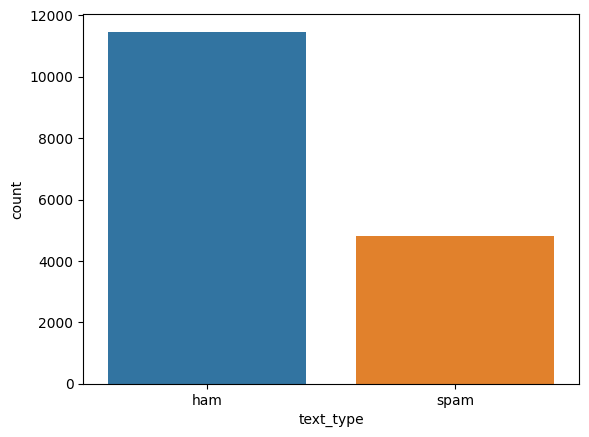

In [6]:
sns.countplot(x=df['text_type']);

Следовательно у нас дисбаланс классов: в данных спама примерно в 3 раза меньше, чем нормальных сообщений, поэтому при разделении на тренировачный и валидационный датасет будем использовать стратификацию.

## 2) анализ текста сообщений

**Посмотрим есть ли пропуски в сообщениях:**

In [7]:
df.isna().sum()

text_type    0
text         0
dtype: int64

**Подсчитаем количестов символов, слов и предложений в каждом сообщении:**

In [8]:
# количество символов
df['number_of_symbols'] = df['text'].apply(len)

# количество слов
df['number_of_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

# количество предложений
df['numer_of_sent'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_symbols,16278.0,310.383524,287.818154,1.0,60.0,157.0,639.0,800.0
number_of_words,16278.0,57.124647,52.122445,1.0,12.0,31.0,114.0,207.0
numer_of_sent,16278.0,1.058730,0.350870,1.0,1.0,1.0,1.0,12.0


**Распределение количества символов:**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

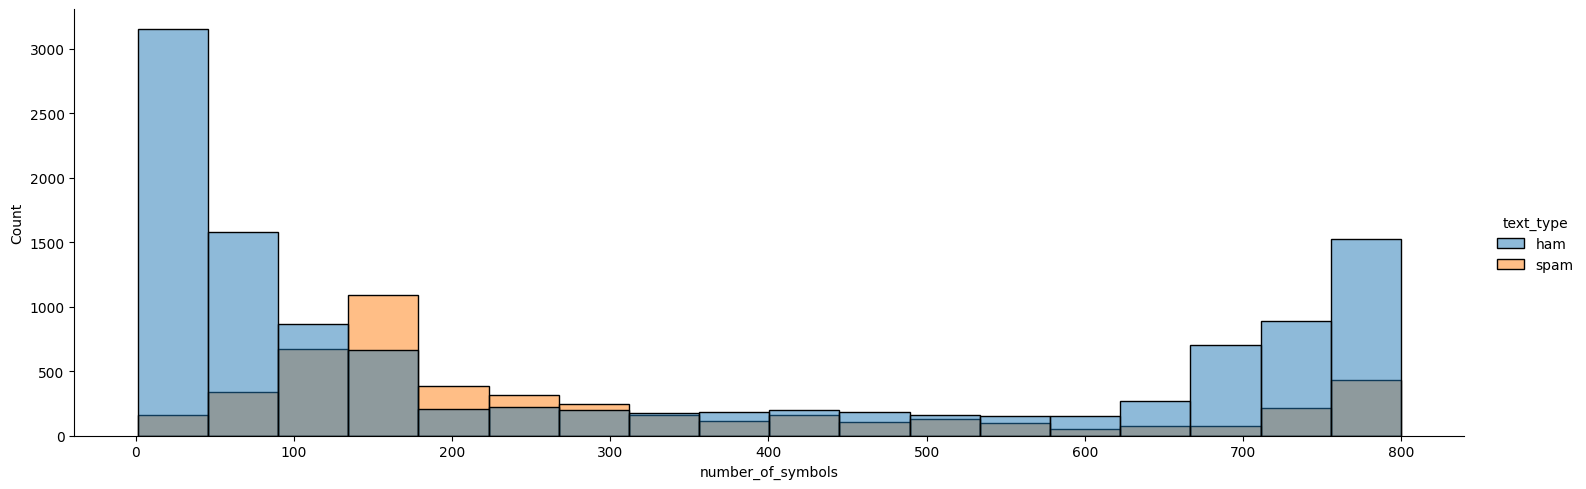

In [10]:
#warnings.filterwarnings('ignore')
g = sns.displot(
    data=df,
    x="number_of_symbols",
    hue="text_type",
    legend=True,
    aspect=3,
    kind="hist",
    alpha=0.5,
);

**Распределение количества слов:**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

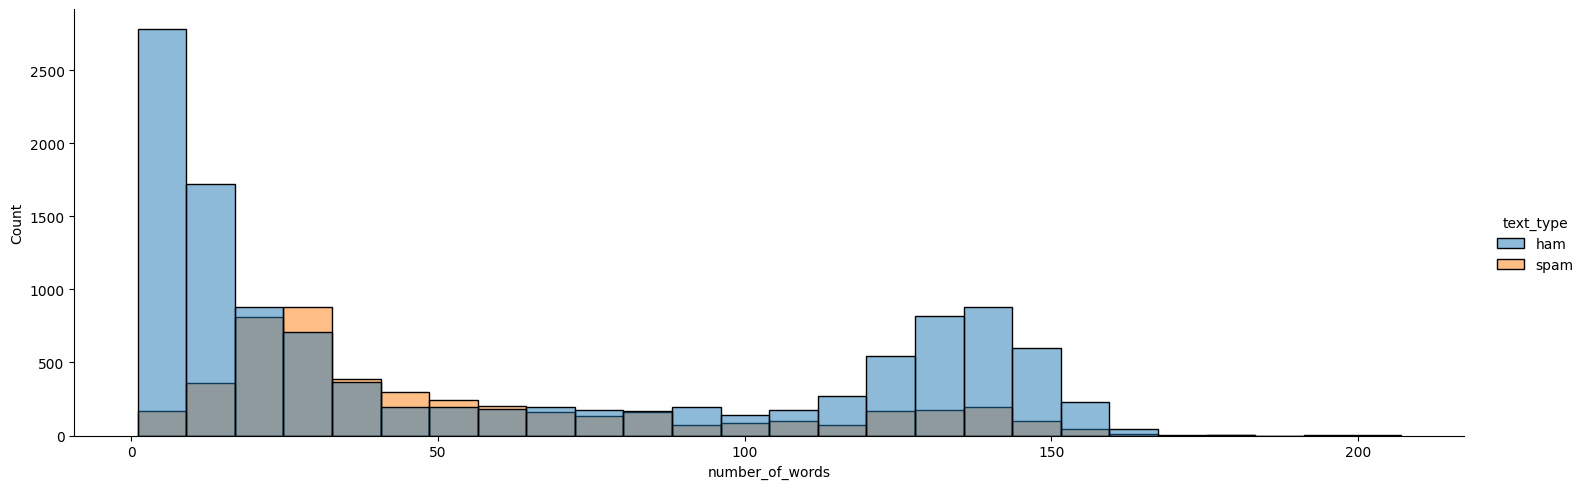

In [11]:
g = sns.displot(
    data=df,
    x="number_of_words",
    hue="text_type",
    legend=True,
    aspect=3,
    kind="hist",
    alpha=0.5,
);

Получается что спама с маленьким количеством слов очень мало, что в целом логично, так как в спаме обычно призывают к чему-то и предлагают какие-то услуги, очевидно что для этого нужно написать хотя бы пару десяток слов, поэтому пик распределения приходится на 30 слов.

**Сравнение содержаний сообщений**

# 2. Обработка текста

In [12]:
stop_words = set(stopwords.words("english"))

In [13]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

for word in stopwordlist:
    if word not in stop_words:
        stop_words.add(word)

In [14]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [15]:
def preprocessing(text):
    for emoji in emojis.keys():
            text = text.replace(emoji, "EMOJI" + emojis[emoji]) 
            
    sms = re.sub('[^a-zA-Z]', ' ', text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    
    tokens = nltk.word_tokenize(sms)
    
    filtered_text = [token for token in tokens if token not in stop_words]
    
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in filtered_text]
    
    return ' '.join(tokens)


In [16]:
df['tokenize_text'] = df['text'].apply(preprocessing)

In [17]:
tfid = TfidfVectorizer(max_features=2000)
X = tfid.fit_transform(df['tokenize_text']).toarray()

In [18]:
X.shape

(16278, 2000)

In [19]:
df['target'] = df['text_type'].apply(lambda x: 1 if x == 'spam' else 0)
y = df['target'].values

# 3. Обучение моделей

In [20]:
X_train, X_eval , y_train, y_eval = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2024)

In [22]:
models = {
    'lgbm' : LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=2024),
    'xgboost': xgb.XGBClassifier(objective='binary:hinge',random_state=2024),
    'rfc': RandomForestClassifier(random_state=2024),
    'naive_bayes': MultinomialNB(),
    'svc': SVC(probability=True, random_state=2024)
}

In [23]:
score = {}
for model_name in models:
    models[model_name].fit(X_train, y_train)
    predictions = models[model_name].predict_proba(X_eval)[:,1]
    score[model_name] = roc_auc_score(y_eval, predictions)
    print(f'{model_name}: roc_auc = {score[model_name]}')

[LightGBM] [Info] Number of positive: 3847, number of negative: 9175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73415
[LightGBM] [Info] Number of data points in the train set: 13022, number of used features: 1971
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.295423 -> initscore=-0.869189
[LightGBM] [Info] Start training from score -0.869189
lgbm: roc_auc = 0.9628802063414095
xgboost: roc_auc = 0.8622661122661123
rfc: roc_auc = 0.9678837680145439
naive_bayes: roc_auc = 0.9565956205014617
svc: roc_auc = 0.9571362154186914


In [24]:
score

{'lgbm': 0.9628802063414095,
 'xgboost': 0.8622661122661123,
 'rfc': 0.9678837680145439,
 'naive_bayes': 0.9565956205014617,
 'svc': 0.9571362154186914}

**На данный момент в топ 3 входят: light gbm, случайный лес и наивный байесовский классификатор. Попробуем провести мягкое голосвание среди этих моделей и сравнит полученный roc-auc:**

In [29]:
lgbm = LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=2024)
rfc = RandomForestClassifier(random_state=2024)
naive_bayes = MultinomialNB()

vote_model = VotingClassifier(estimators=[('lgbm', lgbm),
                                      ('rfc', rfc),
                                      ('naive_bayes',naive_bayes)],
                          voting='soft')

vote_model = vote_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3847, number of negative: 9175
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.198610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73415
[LightGBM] [Info] Number of data points in the train set: 13022, number of used features: 1971
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.295423 -> initscore=-0.869189
[LightGBM] [Info] Start training from score -0.869189


In [30]:
predictions = vote_model.predict_proba(X_eval)[:,1]
score['ensemble'] = roc_auc_score(y_eval, predictions)

Text(0, 0.5, 'roc_auc')

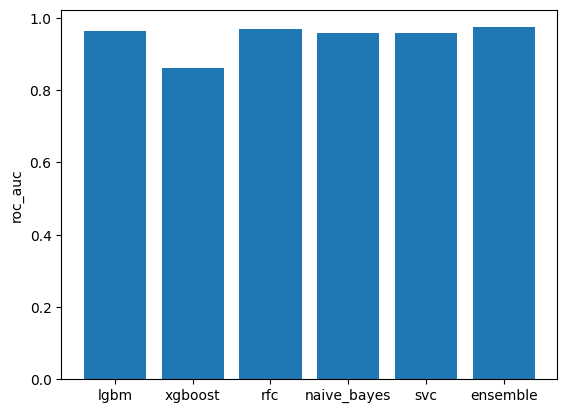

In [44]:
l1 = [key for key in score]
l2 = [score[key] for key in score]
plt.bar(l1, l2)
plt.ylabel('roc_auc')

Видно, что при помощи мягкого голосования(ансамбля моделей) удалось увеличить метрику. Теперь обучим эти модели на всех данных и сделаем предсказание на тестовом датасете:

In [45]:
lgbm = LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=2024)
rfc = RandomForestClassifier(random_state=2024)
naive_bayes = MultinomialNB()

vote_model = VotingClassifier(estimators=[('lgbm', lgbm),
                                      ('rfc', rfc),
                                      ('naive_bayes',naive_bayes)],
                          voting='soft')

vote_model = vote_model.fit(X, y)

[LightGBM] [Info] Number of positive: 4809, number of negative: 11469
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.241900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89198
[LightGBM] [Info] Number of data points in the train set: 16278, number of used features: 1992
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.295429 -> initscore=-0.869159
[LightGBM] [Info] Start training from score -0.869159


# 4. Предсказание на тестовых данных

In [46]:
df_test = pd.read_csv('/kaggle/input/vk-spam/test_spam.csv')

In [47]:
df_test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [48]:
df_test['tokenize_text'] = df_test['text'].apply(preprocessing)

In [49]:
X = tfid.transform(df_test['tokenize_text']).toarray()

In [50]:
X.shape

(4070, 2000)

In [53]:
df_test['score'] = vote_model.predict_proba(X)[:,1]
df_test = df_test.drop(['tokenize_text'], axis=1)

In [55]:
df_test.head()

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,0.028551
1,original message from bitbitch magnesium net p...,0.147911
2,java for managers vince durasoft who just taug...,0.007209
3,there is a youtuber name saiman says,0.092775
4,underpriced issue with high return on equity t...,0.405205


In [58]:
df_test.to_csv('score',index=False)